# Varying SNR

Here we analyze simulated data over a range of SNR where SNR was varied by changing spot intensity $h$ while keeping other parameters constant (Figure 3, Figure 4, Figure 5, Supplementary Data 1 in the manuscript).

## Running simulations & analysis using Slurm

In [ ]:
%load_ext slurm_magic

In [ ]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=height
#SBATCH --output=simulations/height%a_%A.out
#SBATCH --gres=gpu:1   # Request 1 GPU
#SBATCH --array=0-7

heights=(300 500 600 750 1000 1500 2000 3000)

# Path to your executable
python ../examples/cosmos_simulations.py \
  --gain 7 --pi 0.15 --lamda 0.15 --proximity 0.2 \
  -bs 4 --cuda --dtype double \
  --height ${heights[${SLURM_ARRAY_TASK_ID}]} \
  --path simulations/height${heights[${SLURM_ARRAY_TASK_ID}]}

In [ ]:
%squeue

## Load results

In [1]:
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from matplotlib.ticker import FormatStrFormatter

from tapqir.models import Cosmos
from tapqir.utils.dataset import load

In [2]:
# path to simulated data
SIMULATIONS_DIR = Path("simulations")

In [3]:
truth = {}
fit = {}
predictions = defaultdict(dict)

# load results
for data_path in SIMULATIONS_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("height"):
        
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        
        model = Cosmos(verbose=False)
        model.load(data_path, data_only=False)
        
        fit[data_path.name] = model.statistics.drop("trained").astype(float)
        for p in ("gain", "proximity", "pi", "lamda", "SNR"):
            fit[data_path.name].loc[p, "True"] = truth[data_path.name][p]
        
        mask = torch.from_numpy(model.data.ontarget.labels["z"])
        samples = torch.masked_select(model.params["p(specific)"], mask)
        predictions[data_path.name]["z_masked"] = samples
        predictions[data_path.name]["z_all"] = model.params["p(specific)"].flatten()

In [4]:
truth_df = pd.concat(truth.values(), axis=1).T.astype(float)
truth_df = truth_df.sort_values(by="height")
truth_df

,width,gain,pi,lamda,proximity,offset,height,background,SNR,N,F,Nc,Fc,P
height300,1.4,7.0,0.15,0.15,0.2,90.0,300.0,150.0,0.375890,5.0,500.0,5.0,500.0,14.0
height500,1.4,7.0,0.15,0.15,0.2,90.0,500.0,150.0,0.626483,5.0,500.0,5.0,500.0,14.0
height600,1.4,7.0,0.15,0.15,0.2,90.0,600.0,150.0,0.751780,5.0,500.0,5.0,500.0,14.0
height750,1.4,7.0,0.15,0.15,0.2,90.0,750.0,150.0,0.939725,5.0,500.0,5.0,500.0,14.0
height1000,1.4,7.0,0.15,0.15,0.2,90.0,1000.0,150.0,1.252966,5.0,500.0,5.0,500.0,14.0
height1500,1.4,7.0,0.15,0.15,0.2,90.0,1500.0,150.0,1.879450,5.0,500.0,5.0,500.0,14.0
height2000,1.4,7.0,0.15,0.15,0.2,90.0,2000.0,150.0,2.505933,5.0,500.0,5.0,500.0,14.0
height3000,1.4,7.0,0.15,0.15,0.2,90.0,3000.0,150.0,3.758899,5.0,500.0,5.0,500.0,14.0


In [5]:
description = pd.Series(dtype=str, name="Description")
description["N"] = "Number of on-target AOIs"
description["F"] = "Number of frames for on-target AOIs"
description["Nc"] = "Number of control off-target AOIs"
description["Fc"] = "Number of frames for off-target AOIs"
description["P"] = "Number of pixels along x- and y-axes of an AOI"
description["height"] = "Spot intensity"
description["width"] = "Spot width"
description["snr"] = "Signal-to-noise ratio"
description["background"] = "Image background"
description["pi"] = "Average target-specific binding probability"
description["lamda"] = "Non-specific binding rate"
description["proximity"] = "Proximity parameter"
description["p(specific)"] = "Probability of there being any target-specific spot in an AOI image"
description["_ul"] = "95% CI upper-limit"
description["_ll"] = "95% CI lower-limit"
description["MCC"] = "Matthews correlation coefficient"
description["TP"] = "True positives"
description["FN"] = "False negatives"
description["TN"] = "True negatives"
description["FP"] = "False positives"

## Supplementary Data 3

In [6]:
with pd.ExcelWriter("/home/ordabayev/repos/tapqir-overleaf/supplementary/data3/height.xlsx") as writer:
    truth_df.to_excel(writer, sheet_name="simulation")
    for key, value in fit.items():
        value.to_excel(writer, sheet_name=key)
    description.to_excel(writer, sheet_name="description")

## Figures

### Figure 5

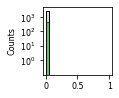

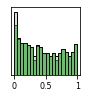

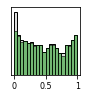

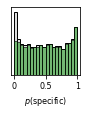

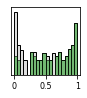

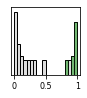

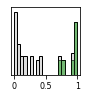

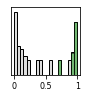

In [9]:
for name in truth_df.index:
    plt.figure(figsize=(1.25, 1.25))
    plt.hist(predictions[name]["z_all"].numpy(),
             bins=np.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="#dddddd", edgecolor="k",
             label=f"{truth_df.loc[name, 'SNR']:.2f} SNR")
    plt.hist(predictions[name]["z_masked"].numpy(),
             bins=np.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="C2", edgecolor="k", alpha=0.6,
             label=f"{truth_df.loc[name, 'SNR']:.2f} SNR")
    plt.yscale("log")
    plt.xlim(-0.05,1.05)
    plt.ylim(1e-1, 5e3)
    plt.xticks([0, 0.5, 1], fontsize=8)
    
    if name == "height300":
        plt.ylabel("Counts", fontsize=8)
        plt.yticks([1, 10, 100, 1000], fontsize=8)
    else:
        plt.yticks([])
    if name == "height750":
        plt.xlabel(r"$p(\mathsf{specific})$", fontsize=8)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
    # plt.legend(loc="upper center", fontsize=8)
    plt.savefig(f"/home/ordabayev/repos/tapqir-overleaf/figures/figure5/{name}.svg")
    plt.show()

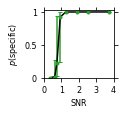

In [10]:
fig, ax = plt.subplots(figsize=(1.25, 1.25))
ax.errorbar(truth_df["SNR"], [fit[i].loc["p(specific)", "Mean"] for i in truth_df.index],
            yerr=np.array([abs(fit[i].loc["p(specific)", ["95% LL", "95% UL"]].values - fit[i].loc["p(specific)", "Mean"]) for i in truth_df.index]).T,
            #yerr=abs(fit_df[["z_ll", "z_ul"]].values.T-fit_df["z_median"].values),
            fmt="o-", ms=3, color="k", mfc="C2", mec="C2", ecolor="C2", capsize=2)
ax.set_xlim(0, 4)
ax.set_ylim(0, 1.03)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_yticks([0, 0.5, 1])
ax.tick_params(axis="x", labelsize=8, top=True)
ax.tick_params(axis="y", labelsize=8, right=True)
ax.set_xlabel("SNR", fontsize=8)
ax.set_ylabel(r"$p(\mathsf{specific})$", fontsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure5/height-pspecific.svg")
plt.show()

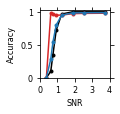

In [11]:
fig, ax = plt.subplots(figsize=(1.25, 1.25))
ax.plot(
    truth_df["SNR"],
    [fit[i].loc["Recall", "Mean"] for i in truth_df.index],
    "o-", color="k", ms=3, label="Recall"
)
ax.plot(
    truth_df["SNR"],
    [fit[i].loc["Precision", "Mean"] for i in truth_df.index],
    "o-", color="C3", ms=3, label="Recall"
)
ax.plot(
    truth_df["SNR"],
    [fit[i].loc["MCC", "Mean"] for i in truth_df.index],
    "o-", color="C0", ms=3, label="Recall"
)
ax.set_xlim(0, 4)
ax.set_ylim(0, 1.03)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_yticks([0, 0.5, 1])
ax.tick_params(axis="x", labelsize=8, top=True)
ax.tick_params(axis="y", labelsize=8, right=True)
ax.set_xlabel("SNR", fontsize=8)
ax.set_ylabel("Accuracy", fontsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.legend(fontsize=8)
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure5/height-accuracy.svg")
plt.show()

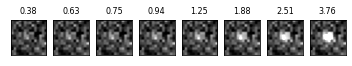

In [12]:
plt.figure(figsize=(6,3))
for i, name in enumerate(truth_df.index):
    plt.subplot(1, len(truth_df), i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(f"{truth_df.loc[name, 'SNR']:.2f}", fontsize=8)
    data = load(SIMULATIONS_DIR / name)
    plt.imshow(data.ontarget.images[3, 222].numpy(), vmin=190, vmax=380, cmap="gray")
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure5/height-images.png", dpi=600)
plt.show()